# Import Library & Set Globals

In [2]:
import os
import warnings
import logging
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
warnings.simplefilter("ignore", pd.errors.DtypeWarning)
logging.basicConfig(level='INFO')
mlogger = logging.getLogger('matplotlib')
mlogger.setLevel(logging.WARNING)

import scanpy as sc
import decoupler as dc
import liana as li 
from pacmap import LocalMAP
from liana.method import cellphonedb

from plot import *
from preprocess import get_cellbender_data,Filter_QC,Filter_Doublet,Normalize,FindVariableGenes,Integrate
from analysis import cell2cell_interactions

/mnt/DATA/home/ethung/snRNAseq_analysis/.venv/lib/python3.12/site-packages/scvi/__init__.py:31: DeprecationWarning: scvi is deprecated, please uninstall scvi via `pip uninstall scvi` and install the new scvi-tools package at github.com/YosefLab/scvi-tools
/mnt/DATA/home/ethung/snRNAseq_analysis/.venv/lib/python3.12/site-packages/phenograph/cluster.py:13: DeprecationWarning: Please import `spmatrix` from the `scipy.sparse` namespace; the `scipy.sparse.base` namespace is deprecated and will be removed in SciPy 2.0.0.
INFO:rpy2.situation:cffi mode is CFFI_MODE.ANY
INFO:rpy2.situation:R home found: /opt/R/4.4.1/lib/R
INFO:rpy2.situation:R library path: /opt/R/4.4.1/lib/R/lib:/usr/local/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/java-11-openjdk-amd64/lib/server
INFO:rpy2.situation:LD_LIBRARY_PATH: /opt/R/4.4.1/lib/R/lib:/usr/local/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/java-11-openjdk-amd64/lib/server
INFO:rpy2.rinterface_lib.embedded:Default options to initialize R: rpy2, --quiet, --no

In [3]:
import rpy2.robjects as ro
from rpy2.robjects.conversion import localconverter
from R import get_converter,R_preload
converter = get_converter()

# R_preload()
%load_ext rpy2.ipython

In [4]:
%matplotlib inline
study = "paper_processed"
R_converted = False

CORES = 10
DATADIR = "../../data"
REFDIR = '../../references'
DOUBLETMETHODS = ['scDblFinder','DoubletFinder','doubletdetection','scrublet']

# Access adata

In [ ]:
filetype = 'h5ad' if R_converted else 'h5'

basedir = os.path.join(DATADIR,'cellbender',study)
samps = os.listdir(basedir)
print(samps)
filt_files = [os.path.join(basedir,s,f'output_filtered.{filetype}') for s in samps]
adata = [get_cellbender_data(file,filetype) for file in filt_files]

for d in adata:
    d.obs['Experiment'], d.obs['Groups'], d.obs['Sample'] = np.array(d.obs['Identifier'].str.split('-').to_list()).T
    d.obs['Condition'], d.obs['Sample Type'] = np.array(d.obs['Groups'].str.split('_').to_list()).T

adata

## Data Structures

#### SingleCellExperiment object (in R) is presented below
![SingleCellExperiment Object (in R)](https://hbctraining.github.io/scRNA-seq/img/sce_description.png)

#### AnnData object (in Python) is similar!
* rowData is stored in `adata.vars`
* colData is stored in `adata.obs`
* reducedDims is stored in `adata.obsm`
* layers are stored in `adata.layers`

# Preprocessing

### QC

In [ ]:
adata = [Filter_QC(dat, mt_ratio=15, ribo_ratio=15) for dat in adata]
PlotQC = True
adata

#### QC Plots

Plot QC Filters for 1 dataset

In [ ]:
if PlotQC:
    # sns.displot(adata[1].obs['total_counts'], bins=100, kde=False).figure
    tmp = adata[0]
    sc.pl.violin(
        tmp,
        ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
        jitter=0.4,
        multi_panel=True
    )
    sc.pl.scatter(tmp, "total_counts", "n_genes_by_counts", color="pct_counts_mt",vmax=100)

Plot QC Metrics for all datasets

In [ ]:
def QC_Plot(df, value, groupby):
    sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

    g = sns.FacetGrid(df, row=groupby, hue=groupby, aspect=15, height=0.5, palette="tab20")

    g.map(sns.kdeplot, value, clip_on=False, fill=True, alpha=1, linewidth=1.5)
    g.map(sns.kdeplot, value, clip_on=False, color="w", lw=2)

    g.map(plt.axhline, y=0, lw=2, clip_on=False)

    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)

    g.map(label, value)

    g.figure.subplots_adjust(hspace=-.6)

    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)

    for ax in g.axes.flat:
        ax.axvline(x=df[value].median(), color='r', linestyle='-')

    return g.figure

if PlotQC:
    df = pd.concat([x.obs for x in adata])
    groupby = 'Groups'
    df = df.sort_values(groupby)

    QC_Plot(df,"log1p_total_counts",groupby)
    QC_Plot(df,"pct_counts_mt",groupby)
    QC_Plot(df,"n_genes",groupby)
    QC_Plot(df,"pct_counts_in_top_20_genes",groupby)

### Doublets

In [ ]:
compare_doublets = False
method = 'doubletdetection'
method_short = 'dd'

if compare_doublets is True:
    for method in DOUBLETMETHODS:
        adata = [Filter_Doublet(dat,method,remove=False) for dat in adata]

else:
    print(f"Doublet Method: {method}")
    adata = [Filter_Doublet(dat,method,remove=True) for dat in adata]
    for dat in adata:
        print(len(dat), dat.uns['doublets_removed'])
        
adata

In [ ]:
# save
annotation = method_short
with open(os.path.join(DATADIR,'processed', study, 'py', '1_preprocessed', f'{annotation}.pickle'), 'wb') as handle:
    pickle.dump(adata, handle)

## Pre-Integration Cell Labels (deprecated)

### CellTypist

In [ ]:
import celltypist
from celltypist import models
models.download_models(force_update = False)
print(models.models_path)


In [ ]:
def Annotate_celltypist(adata, model, modelname):
    #celltypist-specific processing
    tmp = adata.copy()
    sc.pp.normalize_total(tmp,target_sum=1e4)
    sc.pp.log1p(tmp)

    predictions = celltypist.annotate(tmp, model=model, majority_voting=False).to_adata()
    adata.obs[f'{modelname}-label'] = predictions.obs.loc[adata.obs.index,"predicted_labels"]
    adata.obs[f'{modelname}-score'] = predictions.obs.loc[adata.obs.index,"conf_score"]
    return adata

model = models.Model.load(model="Immune_All_Low.pkl")
modelname = "CT_immune_highres"
adata = [Annotate_celltypist(dat,model,modelname) for dat in adata]

model = models.Model.load(model="Immune_All_High.pkl")
modelname = "CT_immune_lowres"
adata = [Annotate_celltypist(dat,model,modelname) for dat in adata]

Visualize

In [ ]:
tmp = adata[1].copy()
sc.pp.neighbors(tmp)
sc.tl.umap(tmp)

In [ ]:
sc.pl.umap(tmp,color=['CT_immune_highres-label','CT_immune_lowres-label'],legend_loc='on adata')
sns.histplot(tmp.obs['CT_immune_lowres-score'])
plt.figure()

f,ax = plt.subplots(2, 1)
_ = sns.histplot(tmp.obs['CT_immune_lowres-score'],ax=ax[0])
_ = sns.histplot(tmp.obs['CT_immune_highres-score'],ax=ax[1])

# Integration

### Integrate

In [ ]:
# load adata
annotation = "scDF"
with open(os.path.join(DATADIR,'processed',study,'py',
                                  '1_preprocessed', f'{annotation}.h5ad'),
                                  'rb') as handle:
    adata = pickle.load(handle)

In [ ]:
batch_column = 'Groups'
hvg_kind = 'seurat'
int_kind = 'harmony'

# merge
adata = sc.concat(adata, join='outer')
adata.raw = adata.copy()

# process & integrate
adata = Normalize(adata, kind='log1p', batch_column=batch_column)
adata = FindVariableGenes(adata, kind=hvg_kind, batch_column=batch_column)
adata = Integrate(adata, kind = int_kind, batch_column=batch_column, use_var_genes=False)

In [ ]:
# save
annotation = "scDF-seuratV3-harmony"
adata.write(os.path.join(DATADIR,'processed',study,'py',
                                  '2_integrated', f'{annotation}.h5ad'))

### Plot

In [ ]:
annotation = "scDF-seuratV3-harmony"
adata = sc.read_h5ad(os.path.join(DATADIR,'processed',study,'py',
                                  '2_integrated', f'{annotation}.h5ad'))

In [ ]:
# plot embeddings
f = plt.figure(figsize=(12,5), layout="constrained")
check_integration(adata, "Groups", f, mini=True)
f = plt.figure(figsize=(18,12), layout="constrained")
check_integration(adata, "Groups", f, nrow=2, ncol=2, mini=False)

In [ ]:
# Feature marker plots
markers = ["Adipoq", "Pdgfra", "Upk3b", "Cdh5", "Rgs5", "Adgre1", "Flt3", "Cpa3", "Skap1", "Igkc"]
sc.pl.umap(adata, color=markers, layer='normalized')
sc.pl.embedding(adata, basis="LocalMAP", color=markers, layer='normalized')

# Analysis

## Overall Clustering

### Cluster

In [ ]:
# load data
annotation = "scDF-seuratV3-harmony"
adata = sc.read_h5ad(os.path.join(DATADIR,'processed',study,'py',
                                  '2_integrated', f'{annotation}.h5ad'))
adata.obs["Groups"] = pd.Categorical(adata.obs["Groups"],categories=['LFD_eWAT', 'HFD_eWAT', 'LFD_iWAT', 'HFD_iWAT'], ordered=True)
adata.raw = adata.copy()

In [ ]:
resolution = 1
compareUMAP = False
recluster = False
groupname = 'leiden'

# leiden clustering
if recluster is True:
    sc.tl.leiden(adata, resolution,random_state=123)
    print(f"{len(adata.obs['leiden'].unique())} clusters found at resolution {int(adata.uns['leiden']['params']['resolution'])}!")

if compareUMAP is True:
    try: 
        del adata.uns["leiden_colors"]
    except KeyError:
        pass

    f = plt.figure(figsize=(12,5), layout="constrained")
    check_integration(adata, "leiden", f, mini=True)

# figure prep
cluster_c = color_gen(adata.obs[groupname])
f = plt.figure(figsize=(25,15),layout="constrained")
sf = f.subfigures(1,2, width_ratios=[2, 1.5])

axs = sf[0].subplots(3,3)
gs = axs[0,0].get_gridspec()
empty_axs(axs)

# Large LocalMAP plot
embedding = "X_umap" # "LocalMAP"
ax = sf[0].add_subplot(gs[:2,:])
sc.pl.embedding(adata, basis=embedding, color=[groupname], ax=ax, show=False,
                legend_loc='on data', legend_fontoutline=2, legend_fontsize=20, palette=cluster_c.to_list())
ax = sf[0].add_subplot(gs[2,0])
sc.pl.embedding(adata, basis=embedding, color=['Groups'], ax=ax, show=False, alpha=0.7)
ax = sf[0].add_subplot(gs[2,1])
sc.pl.embedding(adata, basis=embedding, color=['Condition'], ax=ax, show=False, alpha=0.7)
ax = sf[0].add_subplot(gs[2,2])
sc.pl.embedding(adata, basis=embedding, color=['Sample Type'], ax=ax, show=False, alpha=0.7)

# Violin marker plots
markers = ["Adipoq", "Pdgfra", "Upk3b", "Cdh5", "Rgs5", "Adgre1", "Flt3", "Cpa3", "Skap1", "Igkc"]
cluster_violinplot(adata, markers, groupname, sf[1])

### Doublet Checking
only use on '-hasDoublets' verions!

In [ ]:
sc.pl.embedding(adata, basis='LocalMAP', color = [f"predicted_doublet-{method}" for method in DOUBLETMETHODS],ncols=2)
sc.pl.embedding(adata, basis='LocalMAP', color = 'n_genes')
for method in DOUBLETMETHODS:
    print(adata.obs.groupby('leiden')[f'predicted_doublet-{method}'].mean().sort_values())

In [ ]:
# sc.tl.rank_genes_groups(adata, groupby='leiden')
gene_groups = sc.get.rank_genes_groups_df(adata, group=None)
gene_groups[gene_groups.group == '0'].head(20)

### Annotate

In [ ]:
# Get PangloDB
markers = dc.op.resource('PanglaoDB', organism='mouse')
# Filter by canonical_marker and human
markers = markers[markers['mouse'].astype(bool) & markers['canonical_marker'].astype(bool) & (markers['mouse_sensitivity'].astype(float) > 0.5)]
# Cleaning
markers = markers[~markers.duplicated(['cell_type', 'genesymbol'])]
markers = markers.rename(columns={'cell_type': 'source', 'genesymbol': 'target'})
markers = markers[['source', 'target']]

# fit model
dc.mt.ulm(data=adata, net=markers, tmin=3)
score = dc.pp.get_obsm(adata, key='score_ulm')

# get top cell types
df = dc.tl.rankby_group(adata=score, groupby='leiden', reference='rest', method='t-test_overestim_var')
df = df[df['stat'] > 0]
n_ctypes = 3
ctypes_dict = df.groupby('group').head(n_ctypes).groupby('group')['name'].apply(lambda x: list(x)).to_dict()

# Cell Types of Interest
cell_types = ['Adipocytes', 'Fibroblasts', 'Endothelial cells', 'Pericytes', 'Smooth muscle cells', 'Macrophages', 'Monocytes', 'Dendritic cells', 'T cells']

# Plotting
sc.pl.embedding(score, basis="LocalMAP", color=cell_types, layer='self')
sc.pl.embedding(score, basis="LocalMAP", color='cell_type', layer='self')

f = plt.figure(figsize=(6,10),layout="constrained")
cluster_violinplot(score,cell_types,'leiden',f,'self')

In [ ]:
remap = True

if remap is True:
    mapping = {
        0  : 'Adipocyte',  1  : 'Fibroblast',  2  : 'Fibroblast',   3  : 'Adipocyte',  4  : 'Macrophage',
        5  : 'Fibroblast',   6  : 'Adipocyte',   7  : 'Adipocyte',  8  : 'Macrophage', 9  : 'Adipocyte',
        10 : 'Adipocyte',   11 : 'Endothelial',   12 : 'Endothelial',   13 : 'Fibroblast',   14 : 'Mesothelial',
        15 : 'Macrophage',  16 : 'PC/SMC',   17 : 'Adipocyte',   18 : 'Adipocyte',   19 : 'Dendritic Cell',
        20 : 'Macrophage',  21 : 'Fibroblast',  22 : 'T cell',  23 : 'Macrophage',
    }

    try:
        assert len(mapping) == len(adata.obs['leiden'].unique())
    except AssertionError:
        print(f"At resolution {resolution}, {len(adata.obs['leiden'].unique())} clusters identified, but only {len(mapping)} mappings provided!")

    adata.obs['cell_type'] = adata.obs['leiden'].astype(int).replace(mapping)
    adata.obs['cell_type'] = pd.Categorical(adata.obs['cell_type'],
                                            categories=['Adipocyte', 'Fibroblast', 'Mesothelial', 'Endothelial', 'PC/SMC', 'Macrophage', 'Dendritic Cell', 'T cell'],
                                            ordered=True)

for obsm in ["X_umap", "LocalMAP"]:
    f,axs = plt.subplots(1,3,figsize=(20,5),layout='constrained')
    sc.pl.embedding(adata, basis=obsm, color=['leiden'], ax=axs[0], show=False, palette=color_gen(adata.obs["leiden"]).to_list())
    sc.pl.embedding(adata, basis=obsm, color = ['cell_type'], ax=axs[1], show=False, palette=color_gen(adata.obs['cell_type']).to_list())
    sc.pl.embedding(adata, basis=obsm, color = ['Groups'], ax=axs[2], show=False, palette=color_gen(adata.obs['Groups']).to_list(), alpha=0.5)

In [ ]:
# figure prep
groupname = "cell_type"
cluster_c = color_gen(adata.obs[groupname])
f = plt.figure(figsize=(25,15),layout="constrained")
sf = f.subfigures(1,2, width_ratios=[2, 1.5])

axs = sf[0].subplots(3,3)
gs = axs[0,0].get_gridspec()
empty_axs(axs)

# Large LocalMAP plot
embedding = "LocalMAP" # "X_umap"
ax = sf[0].add_subplot(gs[:2,:])
sc.pl.embedding(adata, basis=embedding, color=[groupname], ax=ax, show=False,
                legend_loc='on data', legend_fontoutline=2, legend_fontsize=20, palette=cluster_c.to_list())
ax = sf[0].add_subplot(gs[2,0])
sc.pl.embedding(adata, basis=embedding, color=['Groups'], ax=ax, show=False, alpha=0.7)
ax = sf[0].add_subplot(gs[2,1])
sc.pl.embedding(adata, basis=embedding, color=['Condition'], ax=ax, show=False, alpha=0.7)
ax = sf[0].add_subplot(gs[2,2])
sc.pl.embedding(adata, basis=embedding, color=['Sample Type'], ax=ax, show=False, alpha=0.7)

# Violin marker plots
markers = ["Adipoq", "Pdgfra", "Upk3b", "Cdh5", "Rgs5", "Adgre1", "Flt3", "Cpa3", "Skap1", "Igkc"]
cluster_violinplot(adata, markers, groupname, sf[1])

In [ ]:
f = plt.figure(figsize=(10, 5), layout="constrained")
axs = f.subplots(1, 2)
cluster_stackedbarplot(adata, "Groups", "cell_type", pct=False, ax=axs[0])
cluster_stackedbarplot(adata, "Groups", "cell_type", pct=True, ax=axs[1])

f = plt.figure(figsize=(10, 5), layout="constrained")
axs = f.subplots(1, 2)
cluster_stackedbarplot(adata, "cell_type", "Groups", pct=False, ax=axs[0])
cluster_stackedbarplot(adata, "cell_type", "Groups", pct=True, ax=axs[1])

### DEGs

In [ ]:
sc.tl.rank_genes_groups(adata, groupby='cell_type',
                        use_raw=False, layer="normalized", key_added='de_all',
                        method='wilcoxon')

f, ax = plt.subplots(1,1,figsize=(30,5),layout="constrained")
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="cell_type", key='de_all',
    standard_scale="var", n_genes=10,
    var_group_rotation=30, ax=ax
)

comparison = ["Adipocyte", "Fibroblast", "Macrophage"]
f, ax = plt.subplots(1,1,figsize=(30,5),layout="constrained")
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="cell_type", groups=comparison, key='de_all',
    standard_scale="var", n_genes=30,
    var_group_rotation=30, ax=ax
)

df = sc.get.rank_genes_groups_df(adata, group=None, key='de_all')

In [ ]:
marker_of_interest = "Adgre1"
df[df["names"] == marker_of_interest]

celltype_of_interest = "Adipocyte"
df[df["group"] == celltype_of_interest].head(50)

### Psuedobulk DEGs

see Decoupler PB https://decoupler.readthedocs.io/en/latest/notebooks/scell/rna_psbk.html#differential-expression-analysis
in-depth design matrix discussion: https://f1000research.com/articles/9-1444

In [ ]:
pdata = dc.pp.pseudobulk(
    adata,
    sample_col="Groups",
    groups_col="cell_type",
    # min_prop=0.1,
    # min_smpls=3,
    layer="counts",
    raw=False
)
pdata.layers["counts"] = pdata.X.copy()

# Does PC1 captures a meaningful biological or technical fact?
pdata.obs["lib_size"] = pdata.X.sum(1)

# Normalize
sc.pp.normalize_total(pdata, target_sum=1e4)
sc.pp.log1p(pdata)

logFCs, pvals = dc.pp.contrast(
    pdata,
    group_col="cell_type",
    condition_col="condition",
    condition="stim",
    reference="ctrl",
    method="t-test",
)

### GSEA
* uses `m2.cp.v2025.1.Mm.symbols.gmt`, downloaded from [here](https://www.gsea-msigdb.org/gsea/msigdb/mouse/collections.jsp?targetSpeciesDB=Mouse#M2) (6/2025)

In [5]:
def plot_gsea(adata, key='score_ulm', n_markers=5, flip=True):
    score = dc.pp.get_obsm(adata=adata, key=key)
    df = dc.tl.rankby_group(
        adata=score,
        groupby='cell_type',
        reference='rest',
        method='wilcoxon'
    )
    df = df[df['stat'] > 0]
    
    source_markers = (
        df
        .groupby('group')
        .head(n_markers)
        .drop_duplicates('name')
        .groupby('group')
        ['name']
        .apply(lambda x: list(x))
        .to_dict()
    )
    print(source_markers)
    sc.pl.matrixplot(
        adata=score,
        var_names=source_markers,
        groupby='cell_type',
        dendrogram=True,
        standard_scale='var',
        colorbar_title='Z-scaled scores',
        cmap='RdBu',
        swap_axes=flip,
    )

# output = dc.mt.gsea(data=adata, net=reactome, layer="normalized", verbose=True)
# output = dc.mt.decouple(data=adata, net=reactome, layer="normalized", verbose=True)
# output = dc.mt.ulm(data=adata, net=reactome, layer="normalized", verbose=True)

In [ ]:
for celltype in adata.obs['cell_type'].cat.categories:
    adata[adata.obs['cell_type'] == celltype]

AGGACTTTCGACGACC-1_GSM7747185-LFD_eWAT-1         PC/SMC
CCTATCGTCATAGCAC-1_GSM7747185-LFD_eWAT-1      Adipocyte
TACATTCCATGACTGT-1_GSM7747185-LFD_eWAT-1      Adipocyte
TTGTTCACACAGTCGC-1_GSM7747185-LFD_eWAT-1    Endothelial
CCTCCTCGTAGCTTAC-1_GSM7747185-LFD_eWAT-1      Adipocyte
                                               ...     
CTCCCAATCAAATGCC-1_GSM7747188-HFD_iWAT-1     Fibroblast
GTTGAACAGTCACTCA-1_GSM7747188-HFD_iWAT-1     Fibroblast
GTGTCCTCAAGTAGTA-1_GSM7747188-HFD_iWAT-1     Fibroblast
TTATTGCTCAAGCGTT-1_GSM7747188-HFD_iWAT-1      Adipocyte
AGGAATACATGGCCAC-1_GSM7747188-HFD_iWAT-1     Fibroblast
Name: cell_type, Length: 13861, dtype: category
Categories (8, object): ['Adipocyte' < 'Fibroblast' < 'Mesothelial' < 'Endothelial' < 'PC/SMC' < 'Macrophage' < 'Dendritic Cell' < 'T cell']

INFO:root:ulm - Running ulm
INFO:root:Extracted omics mat with 13861 rows (observations) and 18707 columns (features)
net['weight'] = 1
INFO:root:Network adjacency matrix has 8416 unique features and 1678 unique sources


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:ulm - fitting 1678 univariate models of 18707 observations (targets) with 18705 degrees of freedom
INFO:root:ulm - adjusting p-values by FDR
INFO:root:ulm - done


{'Adipocyte': ['REACTOME_BIOTIN_TRANSPORT_AND_METABOLISM', 'REACTOME_BRANCHED_CHAIN_AMINO_ACID_CATABOLISM', 'REACTOME_GLYCEROPHOSPHOLIPID_BIOSYNTHESIS', 'REACTOME_TRIGLYCERIDE_BIOSYNTHESIS', 'WP_ADIPOGENESIS_GENES'], 'Dendritic Cell': ['REACTOME_REGULATION_OF_T_CELL_ACTIVATION_BY_CD28_FAMILY', 'REACTOME_PHOSPHORYLATION_OF_CD3_AND_TCR_ZETA_CHAINS', 'REACTOME_GENERATION_OF_SECOND_MESSENGER_MOLECULES', 'REACTOME_FCGAMMA_RECEPTOR_FCGR_DEPENDENT_PHAGOCYTOSIS', 'WP_G13_SIGNALING_PATHWAY'], 'Endothelial': ['REACTOME_CELL_JUNCTION_ORGANIZATION', 'REACTOME_GLUCAGON_LIKE_PEPTIDE_1_GLP1_REGULATES_INSULIN_SECRETION', 'BIOCARTA_CELL2CELL_PATHWAY', 'REACTOME_AQUAPORIN_MEDIATED_TRANSPORT', 'REACTOME_APOPTOTIC_CLEAVAGE_OF_CELL_ADHESION_PROTEINS'], 'Fibroblast': ['REACTOME_DERMATAN_SULFATE_BIOSYNTHESIS', 'WP_INFLAMMATORY_RESPONSE_PATHWAY', 'REACTOME_GLYCOSAMINOGLYCAN_METABOLISM', 'REACTOME_A_TETRASACCHARIDE_LINKER_SEQUENCE_IS_REQUIRED_FOR_GAG_SYNTHESIS', 'REACTOME_CHONDROITIN_SULFATE_DERMATAN_SULFATE_M

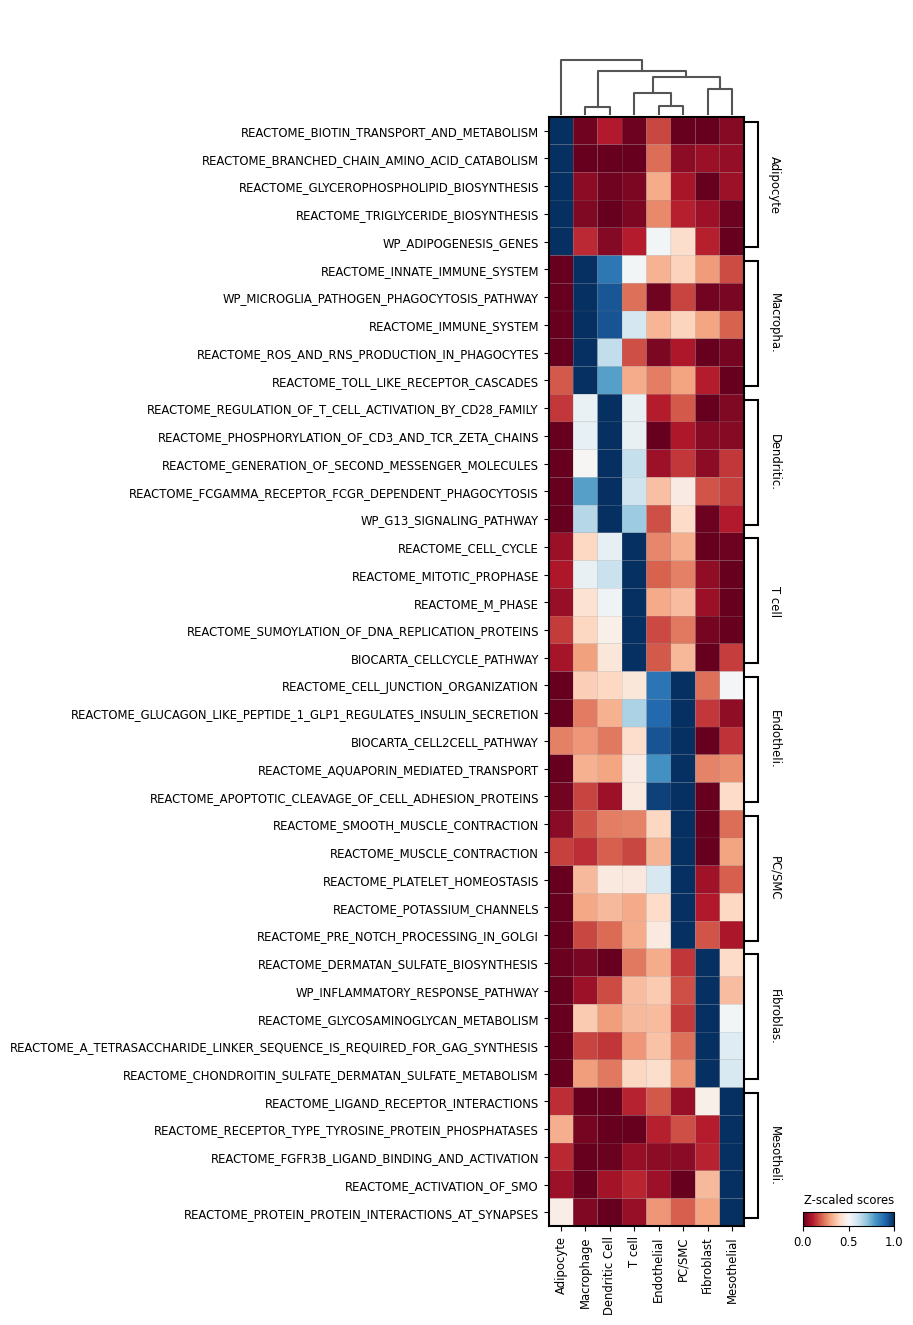

In [ ]:
# msigdb = dc.op.resource("MSigDB", "mouse")
# msigdb_cp = msigdb.query("collection == 'reactome_pathways'")
# msigdb_cp = reactome[~reactome.duplicated(("geneset", "genesymbol"))]

name = "mouse_CP"
reactome = dc.pp.read_gmt(os.path.join(REFDIR,"interactome", "m2.cp.v2025.1.Mm.symbols.gmt"))
dc.mt.ulm(data=adata, net=reactome, layer="normalized", verbose=True)
adata.obsm[f"{name}_score_ulm"] = adata.obsm["score_ulm"]
adata.obsm[f"{name}_padj_ulm"] = adata.obsm["padj_ulm"]
plot_gsea(adata, f"{name}_score_ulm", 5)

name = "Hallmark_ULM"
reactome = dc.pp.read_gmt(os.path.join(REFDIR,"interactome", "mh.all.v2025.1.Mm.symbols.gmt"))
dc.mt.ulm(data=adata, net=reactome, layer="normalized")
adata.obsm[f"{name}_score_ulm"] = adata.obsm["score_ulm"]
adata.obsm[f"{name}_padj_ulm"] = adata.obsm["padj_ulm"]
plot_gsea(adata, f"{name}_score_ulm", 5)

name = "dcHallmark_ULM"
reactome = dc.op.hallmark(organism='mouse')
dc.mt.ulm(data=adata, net=reactome, layer="normalized")
adata.obsm[f"{name}_score_ulm"] = adata.obsm["score_ulm"]
adata.obsm[f"{name}_padj_ulm"] = adata.obsm["padj_ulm"]
plot_gsea(adata, f"{name}_score_ulm", 5, flip=True)

{'Adipocyte': ['Pou1f1', 'Nr0b1', 'Gfi1', 'Rxra', 'Hnf4g'], 'Dendritic Cell': ['Rfx5', 'Rfxap', 'Rfxank', 'Ciita', 'Zfp160'], 'Endothelial': ['Sox7', 'Asxl1', 'Sox18', 'Gata5'], 'Fibroblast': ['Runx2', 'Zfpm2', 'Scx', 'Fosl1', 'Dlx5'], 'Macrophage': ['Elf1', 'Spic', 'Rel', 'Irf2', 'Spi1'], 'Mesothelial': ['Fezf2', 'Zfp24', 'Ybx3', 'Shox2', 'Foxj1'], 'PC/SMC': ['Mef2c', 'Foxc2', 'Pax7', 'Foxh1', 'Erg'], 'T cell': ['E2f4', 'Mxd1', 'Rest', 'Npm1', 'Hic1']}


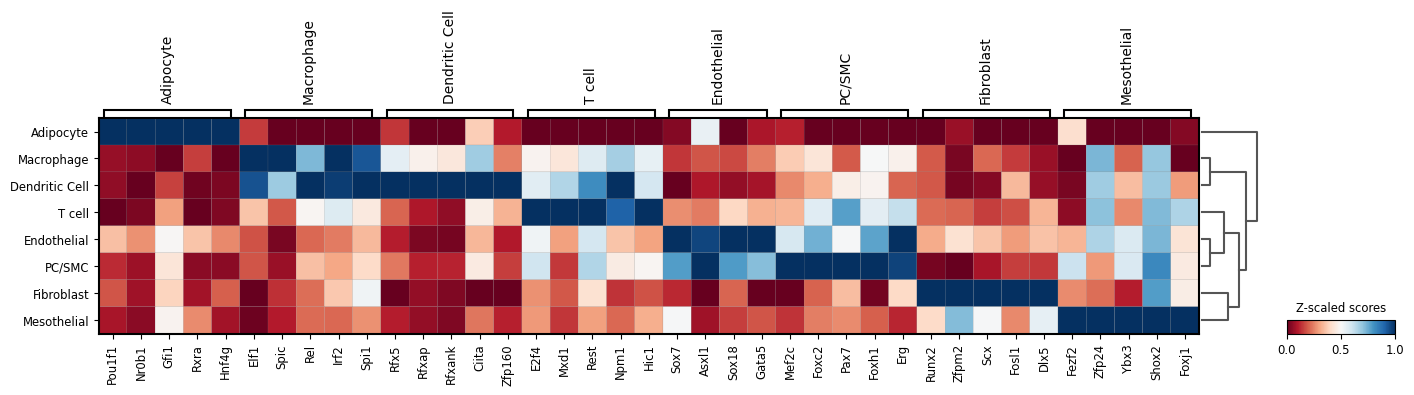

In [ ]:
name = "CollecTRI_ULM"
collectri = dc.op.collectri(organism='mouse')
dc.mt.ulm(data=adata, net=collectri, layer="normalized")
adata.obsm[f"{name}_score_ulm"] = adata.obsm["score_ulm"]
adata.obsm[f"{name}_padj_ulm"] = adata.obsm["padj_ulm"]
plot_gsea(adata, f"{name}_score_ulm", 5, False)

### Save/Load

In [ ]:
# save
annotation = "scDF-seuratV3-harmony-leiden_1.0"
adata.write(os.path.join(DATADIR,'processed',study,'py',
                                  '3_annotated', f'{annotation}.h5ad'))

In [6]:
# load
annotation = "scDF-seuratV3-harmony-leiden_1.0"
adata = sc.read_h5ad(os.path.join(DATADIR,'processed',study,'py',
                                  '3_annotated', f'{annotation}.h5ad'))

##### Create Cloupe

In [ ]:
export = sc.AnnData(X = adata.layers["counts"].copy(),
                    obs = adata.obs[["Identifier", "Experiment", "Groups", "Condition", "Sample Type", "leiden", "cell_type"]].copy(),
                    var = adata.var[["highly_variable","means","variances"]].copy(),
                    obsm = adata.obsm.copy())

with localconverter(converter):
    R_preload()
    ro.globalenv["sce"] = export
    ro.r("""
    library("loupeR")
    clust <- as.list(colData(sce))
    proj <- as.list(reducedDims(sce))
    proj$integrated <- proj$integrated[,1:2]
    proj$PCA <- proj$PCA[,1:2]

    create_loupe(
        assay(sce, "X"),
        clusters = clust, 
        projections = proj,
        output_name = "output",
    )
    """)

## Subclustering

In [ ]:
# load
annotation = "scDF-seuratV3-harmony-leiden_1.0"
adata = sc.read_h5ad(os.path.join(DATADIR,'processed',study,'py',
                                  '3_annotated', f'{annotation}.h5ad'))

### Macrophages

In [ ]:
# subset
adata_macros = adata[adata.obs["cell_type"] == "Macrophage"].copy()
del adata_macros.uns, adata_macros.varm, adata_macros.obsp
sc.pp.filter_cells(adata_macros, min_genes=200)
sc.pp.filter_genes(adata_macros, min_cells=5)

# UMAP
sc.pp.neighbors(adata_macros, use_rep = "integrated")
sc.tl.umap(adata_macros, key_added='umap_macro')

#LocalMAP
lm = LocalMAP()
adata_macros.obsm["LocalMAP_macro"] = lm.fit_transform(adata_macros.obsm['integrated'])

In [ ]:
# integration check
f = plt.figure(figsize=(18,12), layout="constrained")
check_integration(adata_macros, "Groups", f, embeddings=["umap_macro", "LocalMAP_macro"], nrow=2, ncol=2)

#### Clusters

In [ ]:
# cluster
recluster = False
groupname = "leiden_macro"

if recluster is True:
    sc.tl.leiden(adata_macros, resolution=0.5, key_added='leiden_macro')
    order_obs(adata_macros,"leiden_macro",pd.Series([2,1,6,0,4,3,7,5]).astype(str))

# figure prep
cluster_c = color_gen(adata_macros.obs[groupname])
f = plt.figure(figsize=(25,15),layout="constrained")
sf = f.subfigures(1,2, width_ratios=[2, 1])

axs = sf[0].subplots(3,3)
gs = axs[0,0].get_gridspec()
empty_axs(axs)

# Large LocalMAP plot
embedding = "umap_macro" # "LocalMAP_macro"
ax = sf[0].add_subplot(gs[:2,:])
sc.pl.embedding(adata_macros, basis=embedding, color=[groupname], ax=ax, show=False,
                legend_loc='on data', legend_fontoutline=2, legend_fontsize=20, palette=cluster_c.to_list())
ax = sf[0].add_subplot(gs[2,0])
sc.pl.embedding(adata_macros, basis=embedding, color=['Groups'], ax=ax, show=False, alpha=0.7)
ax = sf[0].add_subplot(gs[2,1])
sc.pl.embedding(adata_macros, basis=embedding, color=['Condition'], ax=ax, show=False, alpha=0.7)
ax = sf[0].add_subplot(gs[2,2])
sc.pl.embedding(adata_macros, basis=embedding, color=['Sample Type'], ax=ax, show=False, alpha=0.7)

# Violin marker plots
markers = ["Adgre1", "Cd209f", "Creb5", "Gpnmb", "Cd226", "Plac8", "Slpi", "Col1a2"]
cluster_violinplot(adata_macros, markers, groupname, sf[1])

#### Annotations

In [ ]:
# reannotate
adata_macros.obs["leiden_macro_group"] = adata_macros.obs["leiden_macro"].map(
    {'2' : 1,
     '1' : 2, '6' : 3,
     '0' : 3, '4' : 3, '3' : 3,
     '7' : 4,
     '5' : 5,
     }).astype(str)
order_obs(adata_macros,"leiden_macro_group",pd.Series(np.arange(1,6)).astype(str))

f = plt.figure(figsize=(10, 5), layout="constrained")
axs = f.subplots(1, 2)
cluster_stackedbarplot(adata_macros, "Groups", "leiden_macro_group", pct=False, ax=axs[0])
cluster_stackedbarplot(adata_macros, "Groups", "leiden_macro_group", pct=True, ax=axs[1])

f = plt.figure(figsize=(10, 5), layout="constrained")
axs = f.subplots(1, 2)
cluster_stackedbarplot(adata_macros, "leiden_macro_group", "Groups", pct=False, ax=axs[0])
cluster_stackedbarplot(adata_macros, "leiden_macro_group", "Groups", pct=True, ax=axs[1])

In [ ]:
# figure prep
groupname = "leiden_macro_group"
cluster_c = color_gen(adata_macros.obs[groupname])
f = plt.figure(figsize=(25,15),layout="constrained")
sf = f.subfigures(1,2, width_ratios=[2, 1])

axs = sf[0].subplots(3,3)
gs = axs[0,0].get_gridspec()
empty_axs(axs)

# Large LocalMAP plot
embedding = "LocalMAP_macro" # "umap_macro"
ax = sf[0].add_subplot(gs[:2,:])
sc.pl.embedding(adata_macros, basis=embedding, color=[groupname], ax=ax, show=False,
                legend_loc='on data', legend_fontoutline=2, legend_fontsize=20, palette=cluster_c.to_list())
ax = sf[0].add_subplot(gs[2,0])
sc.pl.embedding(adata_macros, basis=embedding, color=['Groups'], ax=ax, show=False, alpha=0.7)
ax = sf[0].add_subplot(gs[2,1])
sc.pl.embedding(adata_macros, basis=embedding, color=['Condition'], ax=ax, show=False, alpha=0.7)
ax = sf[0].add_subplot(gs[2,2])
sc.pl.embedding(adata_macros, basis=embedding, color=['Sample Type'], ax=ax, show=False, alpha=0.7)

# Violin marker plots
markers = ["Adgre1", "Cd209f", "Creb5", "Gpnmb", "Cd226", "Plac8", "Slpi", "Col1a2"]
cluster_violinplot(adata_macros, markers, groupname, sf[1])

In [ ]:
# our custom markers, grouped by Groups
f = plt.figure(figsize=(20,20),layout="constrained")
clusters = adata_macros.obs['leiden_macro_group'].cat.categories
cs = color_gen(adata.obs['Groups'],adata.obs['Groups'].cat.categories)
sf = f.subfigures(2,len(clusters))

# CX3CR1, CD206, Arg1, TIM4, CD9, TREM2
markers2 = ["Cx3cr1", "Mrc1", "Arg1", "Timd4", "Cd9", "Trem2"]
print(adata_macros.var_names[adata_macros.var_names.isin(markers2)])

for n,cluster in enumerate(clusters):
    cluster_adata = adata_macros[adata_macros.obs['leiden_macro_group'] == cluster]
    cluster_violinplot(cluster_adata, markers2, "Groups", sf[0,n])

    ax = sf[1,n].subplots(1,1)
    crosstab_counts = pd.crosstab(adata_macros.obs["leiden_macro_group"], adata_macros.obs["Groups"])
    crosstab_counts.loc[cluster][crosstab_counts.loc[cluster] > 0].plot(kind="bar", color=cs[crosstab_counts.loc[cluster] > 0], ax=ax)
    ax.tick_params(axis='x', rotation=0)

    sf[0,n].suptitle(f"Cluster {cluster}")

In [ ]:
flow_markers = ["Lyve1", "H2-Ab1", "Mgl2", "Cx3cr1", "Mrc1"]
sc.pl.embedding(adata_macros, basis="umap_macro", color=flow_markers + ["leiden_macro_group"], layer='normalized')

#### DEGs

In [ ]:
# find DEGs
sc.tl.rank_genes_groups(adata_macros, groupby='leiden_macro_group', key_added="de_macro",
                        use_raw=False, layer="normalized", 
                        method='wilcoxon')

# del adata_macros.uns['dendrogram_leiden_macro'], adata_macros.uns['dendrogram_leiden_macro_group']
f, ax = plt.subplots(1,1,figsize=(15,5),layout="constrained")
sc.pl.rank_genes_groups_dotplot(
    adata_macros, groupby="leiden_macro_group", key='de_macro',
    standard_scale="var", n_genes=10, min_logfoldchange=2, ax=ax
)

df = sc.get.rank_genes_groups_df(adata_macros, group=None, key="de_macro")

In [ ]:
# our custom markers

f = plt.figure(figsize=(50,10),layout="constrained")
sf = f.subfigures(1,5)
clusters = adata_macros.obs['leiden_macro_group'].cat.categories
# markers2 = ["Cx3cr1", "Mrc1", "Arg1", "Timd4", "Cd9", "Trem2"]
genes = [["Pecam1", "Fabp4", "Cdh5", "Cdh13", "Ptprb", "Adgrf5", "Mgll", "Etl4", "Gpihbp1", "Mecom"],
        ["F13a1", "Rbpj", "Mrc1", "Maf", "Slc9a3r2", "Ctss", "Gas6", "Serinc3", "Fcgr2b", "Ap2a2"],
        ["Lgals3", "Lipa", "Ctse", "Adam8", "Atp6v0d2", "Trem2", "Psap", "Plin2", "Mfsd12", "Ms4a6c"],
        ["Jarid2", "Klf2", "Gsr", "Ccr2", "Ifitm6", "Arhgap26", "Plcb1", "Itgal", "Itga4", "Fam49b"],
        ["Flnb", "Prg4", "Emilin2", "Thbs1", "Fn1", "Itga6", "Ssh2", "Alox15", "Ltbp1", "Itgam"]
]

for g,gene in enumerate(genes):
    cluster_violinplot(adata_macros, gene, "leiden_macro_group", sf[g])

#### Save/Load

In [ ]:
# save
annotation = "scDF-seuratV3-harmony-leiden_1.0-macro_leiden_0.5"
adata_macros.write(os.path.join(DATADIR,'processed',study,'py',
                                  '4.0_subclustered', f'{annotation}.h5ad'))

In [ ]:
# load
annotation = "scDF-seuratV3-harmony-leiden_1.0-macro_leiden_0.5"
adata_macros = sc.read_h5ad(os.path.join(DATADIR,'processed',study,'py',
                                  '4.0_subclustered', f'{annotation}.h5ad'))

### Fibroblasts

In [ ]:
# subset
adata_fibros = adata[adata.obs["cell_type"] == "Fibroblast"].copy()
del adata_fibros.uns, adata_fibros.varm, adata_fibros.obsp
sc.pp.filter_cells(adata_fibros, min_genes=200)
sc.pp.filter_genes(adata_fibros, min_cells=5)

# UMAP
sc.pp.neighbors(adata_fibros, use_rep = "integrated")
sc.tl.umap(adata_fibros, key_added='umap_fibro')

#LocalMAP
lm = LocalMAP()
adata_fibros.obsm["LocalMAP_fibro"] = lm.fit_transform(adata_fibros.obsm['integrated'])

In [ ]:
# integration check
f = plt.figure(figsize=(18,12), layout="constrained")
check_integration(adata_fibros, "Groups", f, embeddings=["umap_fibro", "LocalMAP_fibro"], nrow=2, ncol=2)

#### Clusters

In [ ]:
# cluster
recluster = False
groupname = "leiden_fibro"

if recluster is True:
    sc.tl.leiden(adata_fibros, resolution=0.5, key_added='leiden_fibro')
    order_obs(adata_fibros,"leiden_fibro",pd.Series([2,1,6,0,4,3,7,5]).astype(str))

# figure prep
cluster_c = color_gen(adata_fibros.obs[groupname])
f = plt.figure(figsize=(25,15),layout="constrained")
sf = f.subfigures(1,2, width_ratios=[2, 1])

axs = sf[0].subplots(3,3)
gs = axs[0,0].get_gridspec()
empty_axs(axs)

# Large LocalMAP plot
embedding = "umap_fibro" # "LocalMAP_fibro"
ax = sf[0].add_subplot(gs[:2,:])
sc.pl.embedding(adata_fibros, basis=embedding, color=[groupname], ax=ax, show=False,
                legend_loc='on data', legend_fontoutline=2, legend_fontsize=20, palette=cluster_c.to_list())
ax = sf[0].add_subplot(gs[2,0])
sc.pl.embedding(adata_fibros, basis=embedding, color=['Groups'], ax=ax, show=False, alpha=0.7)
ax = sf[0].add_subplot(gs[2,1])
sc.pl.embedding(adata_fibros, basis=embedding, color=['Condition'], ax=ax, show=False, alpha=0.7)
ax = sf[0].add_subplot(gs[2,2])
sc.pl.embedding(adata_fibros, basis=embedding, color=['Sample Type'], ax=ax, show=False, alpha=0.7)

# Violin marker plots
markers = ["Pdgfra", "Dpp4", "Cd55", "F3", "Lpl"]
cluster_violinplot(adata_fibros, markers, groupname, sf[1])

#### Annotation

In [ ]:
# reannotate
adata_fibros.obs["leiden_fibro_group"] = adata_fibros.obs["leiden_fibro"].map(
    {'1' : 1, '3' : 1, '5' : 1,
     '0' : 2,
     '2' : 3,
     '4' : 4,
     }).astype(str)
order_obs(adata_fibros,"leiden_fibro_group",pd.Series(np.arange(1,5)).astype(str))

f = plt.figure(figsize=(10, 5), layout="constrained")
axs = f.subplots(1, 2)
cluster_stackedbarplot(adata_fibros, "Groups", "leiden_fibro_group", pct=False, ax=axs[0])
cluster_stackedbarplot(adata_fibros, "Groups", "leiden_fibro_group", pct=True, ax=axs[1])

f = plt.figure(figsize=(10, 5), layout="constrained")
axs = f.subplots(1, 2)
cluster_stackedbarplot(adata_fibros, "leiden_fibro_group", "Groups", pct=False, ax=axs[0])
cluster_stackedbarplot(adata_fibros, "leiden_fibro_group", "Groups", pct=True, ax=axs[1])

In [ ]:
# figure prep
groupname = "leiden_fibro_group"
cluster_c = color_gen(adata_fibros.obs[groupname])
f = plt.figure(figsize=(25,15),layout="constrained")
sf = f.subfigures(1,2, width_ratios=[2, 1])

axs = sf[0].subplots(3,3)
gs = axs[0,0].get_gridspec()
empty_axs(axs)

# Large LocalMAP plot
embedding = "LocalMAP_fibro" # "umap_fibro"
ax = sf[0].add_subplot(gs[:2,:])
sc.pl.embedding(adata_fibros, basis=embedding, color=[groupname], ax=ax, show=False,
                legend_loc='on data', legend_fontoutline=2, legend_fontsize=20, palette=cluster_c.to_list())
ax = sf[0].add_subplot(gs[2,0])
sc.pl.embedding(adata_fibros, basis=embedding, color=['Groups'], ax=ax, show=False, alpha=0.7)
ax = sf[0].add_subplot(gs[2,1])
sc.pl.embedding(adata_fibros, basis=embedding, color=['Condition'], ax=ax, show=False, alpha=0.7)
ax = sf[0].add_subplot(gs[2,2])
sc.pl.embedding(adata_fibros, basis=embedding, color=['Sample Type'], ax=ax, show=False, alpha=0.7)

# Violin marker plots
markers = ["Pdgfra", "Dpp4", "Cd55", "F3", "Lpl"]
cluster_violinplot(adata_fibros, markers, groupname, sf[1])

#### DEGs

In [ ]:
# find DEGs
sc.tl.rank_genes_groups(adata_fibros, groupby='leiden_fibro_group', key_added="de_fibro",
                        use_raw=False, layer="normalized", 
                        method='wilcoxon')

# del adata_fibros.uns['dendrogram_leiden_fibro'], adata_fibros.uns['dendrogram_leiden_fibro_group']
f, ax = plt.subplots(1,1,figsize=(15,5),layout="constrained")
sc.pl.rank_genes_groups_dotplot(
    adata_fibros, groupby="leiden_fibro_group", key='de_fibro',
    standard_scale="var", n_genes=10, min_logfoldchange=2, ax=ax
)

df = sc.get.rank_genes_groups_df(adata_fibros, group=None, key="de_fibro")

#### Save/Load

In [ ]:
# save
annotation = "scDF-seuratV3-harmony-leiden_1.0-fibro_leiden_0.5"
adata_fibros.write(os.path.join(DATADIR,'processed',study,'py',
                                  '4.0_subclustered', f'{annotation}.h5ad'))

In [ ]:
# load
annotation = "scDF-seuratV3-harmony-leiden_1.0-fibro_leiden_0.5"
adata_fibros = sc.read_h5ad(os.path.join(DATADIR,'processed',study,'py',
                                  '4.0_subclustered', f'{annotation}.h5ad'))

## CCC

In [ ]:
# load
annotation = "scDF-seuratV3-harmony-leiden_1.0"
adata = sc.read_h5ad(os.path.join(DATADIR,'processed',study,'py',
                                  '3_annotated', f'{annotation}.h5ad'))

annotation = "scDF-seuratV3-harmony-leiden_1.0-macro_leiden_0.5"
adata_macros = sc.read_h5ad(os.path.join(DATADIR,'processed',study,'py',
                                  '4.0_subclustered', f'{annotation}.h5ad'))

annotation = "scDF-seuratV3-harmony-leiden_1.0-fibro_leiden_0.5"
adata_fibros = sc.read_h5ad(os.path.join(DATADIR,'processed',study,'py',
                                  '4.0_subclustered', f'{annotation}.h5ad'))

### All Cells

In [ ]:
# ligand & receptor
cell2cell_interactions(adata, cores=CORES)
cell_interest = ["Fibroblast","Macrophage"]
cluster_c2c(adata, "ccc_aggregate_filtered", sources=cell_interest, targets=cell_interest,
              top_n=50, figsize=(15,10))

# Save as CSV
filtered = adata.uns["ccc_aggregate_filtered"].copy()
filtered_macfib = filtered[filtered.source.isin(cell_interest) & filtered.target.isin(cell_interest)]
# filtered_macfib.to_csv("filtered_macro_fibro_interactions")

### Fibros & Macros

In [ ]:
adata_fms = sc.concat([adata_fibros,adata_macros], join='outer')
adata_fms.raw = dc.pp.swap_layer(adata_fms, "counts")
adata_fms.obs['Subclusters'] = (pd.concat(['Fibroblast_' + adata_fms.obs['leiden_fibro_group'].dropna().astype(str),
                                           'Macrophage_' + adata_fms.obs['leiden_macro_group'].dropna().astype(str)])
                                .astype('category'))
order_obs(adata_fms, 'Subclusters',
          pd.concat([pd.Series('Fibroblast_' + adata_fms.obs['leiden_fibro_group'].cat.categories),
                     pd.Series('Macrophage_' + adata_fms.obs['leiden_macro_group'].cat.categories)]))
cell2cell_interactions(adata_fms, cell_group='Subclusters', key="ccc_FMs", cores=CORES)

In [ ]:
cluster_c2c(adata_fms, "ccc_FMs_filtered", top_n=100, figsize=(25,10))

### Save/Load

In [ ]:
# save
annotation = "scDF-seuratV3-harmony-leiden_1.0"
adata.write(os.path.join(DATADIR,'processed',study,'py',
                                  'cell_communication', f'{annotation}.h5ad'))

In [ ]:
# load
annotation = "scDF-seuratV3-harmony-leiden_1.0"
adata = sc.read_h5ad(os.path.join(DATADIR,'processed',study,'py',
                                  'cell_communication', f'{annotation}.h5ad'))

### Model-Specific

##### CellPhoneDB only

In [ ]:
# cellphoneDB only
cellphonedb(
    adata, groupby="cell_type", layer='normalized', use_raw=False, key_added="ccc_cellphoneDB",
    return_all_lrs=True, verbose=True, n_jobs=10, resource=ccc_db[["ligand", "receptor"]]
)
adata.uns["ccc_cellphoneDB"] = adata.uns["ccc_cellphoneDB"].merge(ccc_db[['ligand', 'receptor', 'db_sources']],
                                                                  left_on=["ligand_complex", "receptor_complex"],
                                                                  right_on=['ligand','receptor'],
                                                                  how='left')
print(np.sum(adata.uns["ccc_cellphoneDB"]["cellphone_pvals"] < 0.01))
adata.uns["ccc_cellphoneDB"]

##### CellChat only

In [ ]:
li.method.cellchat(
    adata, groupby="cell_type", layer='normalized', use_raw=False, key_added="ccc_cellchat",
    return_all_lrs=True, verbose=True, n_jobs=10, resource=ccc_db[["ligand", "receptor"]])
adata.uns["ccc_cellchat"] = adata.uns["ccc_cellchat"].merge(ccc_db[['ligand', 'receptor', 'db_sources']],
                                                                  left_on=["ligand_complex", "receptor_complex"],
                                                                  right_on=['ligand','receptor'],
                                                                  how='left')
adata.uns["ccc_cellchat"]

## Compositional Analysis
* scCODA (clusters) - https://www.sc-best-practices.org/conditions/compositional.html#with-labeled-clusters
* tascCODA (hierachical clusters) - https://www.sc-best-practices.org/conditions/compositional.html#with-labeled-clusters-and-hierarchical-structure
* scanpro (reps, clusters) https://scanpro.readthedocs.io/en/latest/proportion_analysis.html
* Milo (none) https://www.sc-best-practices.org/conditions/compositional.html#without-labeled-clusters

### Save/Load

# Other DEGs Attempts
- [ ] psuedobulking - requires replicates (https://hbctraining.github.io/scRNA-seq/lessons/pseudobulk_DESeq2_scrnaseq.html)
    - [ ] edgeR
    - [ ] decoupleR - https://decoupler-py.readthedocs.io/en/latest/notebooks/scell/rna_psbk.html
- [ ] single cell DEGS
    - [ ] MAST for single cell DEGS
    - [x] Scanpy's Wilcoxon test

In [ ]:
# load
annotation = "scDF-seuratV3-harmony-leiden_1.0"
adata = sc.read_h5ad(os.path.join(DATADIR,'processed',study,'py',
                                  '3_annotated', f'{annotation}.h5ad'))
# R_preload()

#### DESeq2
* https://pydeseq2.readthedocs.io/en/stable/auto_examples/plot_minimal_pydeseq2_pipeline.html
* https://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#note-on-factor-levels

In [ ]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
import decoupler as dc

In [ ]:
pb_adatas = []
for cell_type in adata.obs['cell_type'].unique():
    cell_pop = adata[adata.obs["cell_type"] == cell_type].copy()
    pb_cell_pop = sc.get.aggregate(cell_pop,by='Groups',func='sum',layer='counts')
    pb_adata = sc.AnnData(
        X=pb_cell_pop.layers['sum'],
        obs=pb_cell_pop.obs,
        var=pb_cell_pop.var.copy()
    )
    pb_adata.obs['cell_type'] = cell_type
    pb_adatas.append(pb_adata)

pb = sc.concat(pb_adatas)
pb.obs[['Condition', 'Sample Type']] = pb.obs['Groups'].str.split('_', expand=True)
pb.obs.rename(columns={"Sample Type" : "sample_type", "Condition" : "condition"}, inplace=True)
pb.obs['Index'] = pb.obs['cell_type'] + '-' + pb.obs['Groups'].astype(str)
pb.obs = pb.obs.set_index("Index")
pb.obs["Index"] = pb.obs.index

In [ ]:
inference = DefaultInference(n_cpus=CORES)

# this treats sample types as biological replicates
design = "~0 + condition + cell_type + condition:cell_type"

dds = DeseqDataSet(
    adata=pb,
    design=design,
    refit_cooks=True,
    inference=inference,
)

dds.deseq2()
dds.obsm["design_matrix"]

# dds.fit_size_factors()
# dds.fit_genewise_dispersions()
# dds.fit_dispersion_trend()
# dds.fit_dispersion_prior()
# dds.fit_MAP_dispersions()
# dds.fit_LFC()

# dds.calculate_cooks()
# if dds.refit_cooks:
#     dds.refit()

In [ ]:
print("Model coefficients:")
for i, coef in enumerate(dds.varm['LFC'].columns):
    print(f"{i}: {coef}")

In [ ]:
for col in pb.obs:
    print(col + ":", pb.obs[col].astype(str).unique(),'\n')
dds.obsm['design_matrix'].columns

contrast_diet = ['condition', 'LFD', 'HFD']

contrast_diet_macro = np.zeros(len(dds.obsm["design_matrix"]))
contrast_diet_macro[dds.obsm["design_matrix"].index('condition[T.LFD]')] = 1
contrast_diet_macro[dds.obsm["design_matrix"].index('condition[T.HFD]')] = -1
contrast_diet_macro[dds.obsm["design_matrix"].index('condition[T.LFD]:cell_type[T.Macrophage]')] = 1


contrast_diet_fibro = np.zeros(len(dds.obsm["design_matrix"]))
contrast_diet_fibro[dds.obsm["design_matrix"].index('condition[T.LFD]')] = 1
contrast_diet_fibro[dds.obsm["design_matrix"].index('condition[T.HFD]')] = -1
contrast_diet_fibro[dds.obsm["design_matrix"].index('condition[T.LFD]:cell_type[T.Fibroblast]')] = 1


ds_diet = DeseqStats(
    dds,
    contrast=contrast_diet,
    alpha=0.05,
    cooks_filter=True,
    independent_filter=True,
    inference=inference
)
ds_diet.summary()
df_diet = ds_diet.results_df

# fibroblasts: LFD vs HFD
ds_diet_fibro = DeseqStats(
    dds,
    contrast=contrast_diet,
    alpha=0.05,
    cooks_filter=True,
    independent_filter=True,
    inference=inference
)
ds_diet_fibro.summary()
df_diet_fibro = ds_diet_fibro.results_df

# macros: LFD  vs HFD
ds_diet_macro = DeseqStats(
    dds,
    contrast=contrast_diet,
    alpha=0.05,
    cooks_filter=True,
    independent_filter=True,
    inference=inference
)
ds_diet_macro.summary()
df_diet_macro = ds_diet_macro.results_df

In [ ]:
dc.pl.volcano(df_hfd_lfd, x='log2FoldChange', y='pvalue', figsize=(10,10), top=20)

#### MAST

In [ ]:
adata2 = adata.copy()
adata2.X = adata2.layers["normalized"].copy()

df = pd.DataFrame.sparse.from_spmatrix(data=adata2.X, index=adata2.obs_names, columns=adata2.var_names)
df.join(adata2.obs)
adata_tmp = sc.AnnData(df[adata2.var_names], obs=df.drop(columns=adata2.var_names))

# def prep_anndata(adata_):
#     def fix_dtypes(adata_):
#         for i in [adata_.X, adata_.obs_names, adata_.var_names]:
#             print(i.shape)
#         df = pd.DataFrame(data=adata_.X)#, index=adata_.obs_names, columns=adata_.var_names)
#         df = df.join(adata_.obs)
#         print(df.head())
#         return sc.AnnData(df[adata_.var_names], obs=df.drop(columns=adata_.var_names))

#     adata_ = fix_dtypes(adata_)
#     sc.pp.filter_genes(adata_, min_cells=3)
#     return adata_

# adata_prep = prep_anndata(adata2)
# adata_prep

In [ ]:
adata_tmp

#### EdgeR
* https://pydeseq2.readthedocs.io/en/stable/auto_examples/plot_minimal_pydeseq2_pipeline.html

##### Attempt 2

In [ ]:
with localconverter(converter):
    ro.globalenv['sce'] = adata

In [ ]:
%%R
seurat <- as.Seurat(sce, data = NULL)
seurat
# counts <- GetAssayData(object = seurat, slot = "counts", assay = "RNA")

##### Attempt 1

In [ ]:
pb_adatas = []
for cell_type in adata.obs['cell_type'].unique():
    cell_pop = adata[adata.obs["cell_type"] == cell_type].copy()
    pb_cell_pop = sc.get.aggregate(cell_pop,by='Groups',func='sum',layer='counts')
    pb_adata = sc.AnnData(
        X=pb_cell_pop.layers['sum'],
        obs=pb_cell_pop.obs,
        var=pb_cell_pop.var.copy()
    )
    pb_adata.obs['cell_type'] = cell_type
    pb_adatas.append(pb_adata)
pb = sc.concat(pb_adatas)
pb.obs[['Condition', 'Sample Type']] = pb.obs['Groups'].str.split('_', expand=True)

counts_matrix = pb.X.T
if hasattr(counts_matrix, 'toarray'):
    counts_matrix = counts_matrix.toarray()

print("pb.obs shape:", pb.obs.shape)
print("pb.obs columns:", pb.obs.columns.tolist())
print("pb.obs head:")
print(pb.obs.head())
print("pb.X shape:", pb.X.shape)

In [ ]:
%%R
options(max.print = 300)
cell_type_name = "Macrophage"
ct_samples <- samples[samples$cell_type == cell_type_name, ]
ct_counts <- counts[, rownames(ct_samples), drop=FALSE]
dge <- DGEList(counts = ct_counts, group = rownames(ct_samples))
dge$samples$Condition <- ct_samples$Condition
dge$samples$Sample.Type <- ct_samples$Sample.Type

# Filter low expressed genes
keep <- filterByExpr(dge)
dge <- dge[keep,,keep.lib.sizes=FALSE]
dge <- calcNormFactors(dge)

# Create design matrix
design <- model.matrix(~ Condition + Sample.Type, data = dge$samples)
dge <- estimateDisp(dge, design)
fit <- glmFit(dge, design)

In [ ]:
%%R
lrt_condition <- glmLRT(fit, coef = "ConditionLFD")
topTags(lrt_condition)

In [ ]:
%%R
# Custom contrasts:
# contrasts <- makeContrasts(
#     HFD_vs_LFD_in_eWAT = HFD_eWAT - LFD_eWAT,
#     HFD_vs_LFD_in_iWAT = HFD_iWAT - LFD_iWAT, 
#     eWAT_vs_iWAT_in_HFD = HFD_eWAT - HFD_iWAT,
#     eWAT_vs_iWAT_in_LFD = LFD_eWAT - LFD_iWAT,
#     levels = design
# )


# lrt_condition <- glmLRT(fit)
# lrt <- glmLRT(fit, contrast = contrasts[,"HFD_vs_LFD_in_eWAT"])
# lrt_condition <- glmLRT(fit, coef = "conditionLFD")           # Main effect of diet
# lrt_tissue <- glmLRT(fit, coef = "sample_typeiWAT")           # Main effect of tissue  
# lrt_interaction <- glmLRT(fit, coef = "conditionLFD:sample_typeiWAT"
colnames(design)

In [ ]:
with localconverter(converter):
    ro.globalenv['counts'] = pd.DataFrame(counts_matrix)
    ro.globalenv['metadata'] = pb.obs
    ro.globalenv['gene_names'] = pb.var_names.tolist()
    ro.r("""
        library(edgeR)
        library(dplyr)
        
        counts <- data.frame(counts)
        # Set up count matrix with proper row/column names
        rownames(counts) <- gene_names
        colnames(counts) <- paste(metadata$cell_type, metadata$Groups, sep="_")
        
        # Create sample metadata
        samples <- data.frame(metadata, stringsAsFactors = FALSE)
         
        rownames(samples) <- colnames(counts)
        
        # Function to run EdgeR analysis for each cell type
        run_edger_analysis <- function(cell_type_name) {
            # Subset to specific cell type
            ct_samples <- rownames(samples[samples$cell_type == cell_type_name, ])
            ct_counts <- counts[, ct_samples, drop=FALSE]
            
            # Create DGEList
            dge <- DGEList(counts = ct_counts, samples = ct_samples)
            
            # Filter low expressed genes
            keep <- filterByExpr(dge, group = dge$samples$samples)
            dge <- dge[keep, ]
            
            # Calculate normalization factors
            dge <- calcNormFactors(dge)
            
            # Create design matrix
            design <- model.matrix(~ condition + sample_type, data = dge$samples)
            
            # Estimate dispersions
            dge <- estimateDisp(dge, design)
            
            # Fit GLM
            fit <- glmFit(dge, design)
            
            # Test for condition effect (assuming condition is what you want to test)
            lrt <- glmLRT(fit, coef = "conditionLFD")  # or whichever condition is reference
            
            # Get results
            results <- topTags(lrt, n = Inf)
            results_df <- as.data.frame(results$table)
            results_df$gene <- rownames(results_df)
            results_df$cell_type <- cell_type_name
            
            return(list(
                results = results_df,
                dge = dge,
                fit = fit,
                lrt = lrt
            ))
        }
        
        # Run analysis for each cell type
        cell_types <- unique(samples$cell_type)
        edger_results <- list()
        
        for(ct in cell_types) {
            cat("Analyzing cell type:", ct, "\n")
            edger_results[[ct]] <- run_edger_analysis(ct)
        }
        
        # Combine all results
        all_results <- do.call(rbind, lapply(edger_results, function(x) x$results))
        
        # Add FDR correction across all tests
        all_results$FDR_global <- p.adjust(all_results$PValue, method = "BH")
        
        print("Analysis complete!")
        print(paste("Total DE genes (FDR < 0.05):", sum(all_results$FDR < 0.05)))
        print(paste("Total DE genes (global FDR < 0.05):", sum(all_results$FDR_global < 0.05)))
    """)

# R space

In [ ]:
ro.r("""







""")

# Archive

### Non-Liana

In [ ]:
### NON LIANA APPROACH
R_preload()
with localconverter(converter):
    ro.globalenv["mouse_genes"] = adata.var.index
    ro.r("""
    # see https://neurogenomics.github.io/orthogene/articles/orthogene.html
    genes <- orthogene::convert_orthologs(gene_df = mouse_genes,
                                            gene_output = "dict",
                                            input_species = "mouse",
                                            output_species = "human",
                                            non121_strategy = "drop_input_species",
                                            method = "gprofiler") 
    mappings <- data.frame(genes,row.names=names(genes))
    """)
    mappings = ro.globalenv["mappings"].to_dict()['genes']

converted = adata[:,adata.var_names.isin([m for m in mappings])].copy()
converted.var_names = converted.var_names.map(mappings)

### CellphoneDB v5 ONLY
* Get Database: https://github.com/ventolab/CellphoneDB/blob/master/notebooks/T0_DownloadDB.ipynb
* Prep Data: https://github.com/ventolab/CellphoneDB/blob/master/notebooks/DEGs_calculation/0_prepare_your_data_from_anndata.ipynb
* Run CPDB w/ statistical analysis: https://github.com/ventolab/CellphoneDB/blob/master/notebooks/T1_Method2.ipynb


In [ ]:
tmp_adata = sc.AnnData(X=adata.layers["normalized"].copy(),
                       obs=adata.obs[["cell_type","Groups","Condition","Sample Type", "Identifier"]].copy(),
                       var=pd.DataFrame(index=adata.var.index.copy()))

# load
savedir = os.path.join(DATADIR,'processed',study,'py','cellphonedb', annotation)

# metadata
print(converted.obs['cell_type'].values.describe())
df_meta = pd.DataFrame(data={'Cell':list(converted.obs.index),
                             'cell_type':[ i for i in converted.obs['cell_type']]
                            })
df_meta.set_index('Cell', inplace=True)

if df_meta.columns.isin(["barcode_sample"])[0]:
    assert np.all(converted.obs.index.sort_values() == df_meta["barcode_sample"].sort_values())
else:
    assert np.all(converted.obs.index.sort_values() == df_meta.index.sort_values())

# DEGs
DEGs = sc.get.rank_genes_groups_df(adata, group=None, key='de_all')
cond1 = DEGs['pvals_adj'] < 0.05 
cond2 = DEGs['logfoldchanges'] > 2
mask = [all(tup) for tup in zip(cond1, cond2)]
fDEGs = DEGs[mask]
fDEGs.columns = ["cluster", "gene"] + fDEGs.columns[2:].to_list()

# save relevant info to folder
converted.write(os.path.join(savedir,'counts.h5ad'))
df_meta.to_csv(os.path.join(savedir,'metadata.tsv'), sep = '\t')
fDEGs.to_csv(os.path.join(savedir,'DEGs.tsv'), index=False, sep='\t')

In [ ]:
from cellphonedb.utils import db_utils
from cellphonedb.src.core.methods import cpdb_analysis_method

version = 'v5.0.0'
cpdb_dir = os.path.join(REFDIR,f'cellphoneDB-{version}')
if not os.path.exists(cpdb_dir):
    print(f"Database not found! Downloading to {cpdb_dir}")
    db_utils.download_database(cpdb_dir, version)

cpdb_results = cpdb_analysis_method.call(
    cpdb_file_path = os.path.join(cpdb_dir,"cellphonedb.zip"),          # mandatory: CellphoneDB database zip file.
    meta_file_path = os.path.join(savedir,'metadata.tsv'),              # mandatory: tsv file defining barcodes to cell label.
    counts_file_path = converted,             # mandatory: normalized count matrix - a path to the counts file, or an in-memory AnnData object
    counts_data = 'hgnc_symbol',                                        # defines the gene annotation in counts matrix.
    # microenvs_file_path = microenvs_file_path,                        # optional (default: None): defines cells per microenvironment.
    score_interactions = True,                                          # optional: whether to score interactions or not. 
    output_path = os.path.join(savedir,'output.cpdb'),                  # Path to save results    microenvs_file_path = None,
    separator = '|',                                                    # Sets the string to employ to separate cells in the results dataframes "cellA|CellB".
    threads = 10,                                                       # number of threads to use in the analysis.
    threshold = 0.1,                                                    # defines the min % of cells expressing a gene for this to be employed in the analysis.
    result_precision = 3,                                               # Sets the rounding for the mean values in significan_means.
    debug = False,                                                      # Saves all intermediate tables emplyed during the analysis in pkl format.
    output_suffix = None                                                # Replaces the timestamp in the output files by a user defined string in the  (default: None)
)

In [ ]:
cpdb_results['interaction_scores']